## Astronomy 406 "Computational Astrophysics" (Fall 2024)

## Project 5

### Background

In this project we will continue our investigation of fitting model to data. We will use a new dataset __mgc_mh.dat__ which contains a current version of the relation between the mass of a globular cluster system and its host galaxy. Instead of the host luminosity, it uses the full dynamical mass of the host galaxy $M_h$, including its dark matter halo. The columns are: galaxy mass $\log_{10}{M_h}$, its error estimate $d\log_{10}{M_h}$, combined mass of all globular clusters in each galaxy $\log_{10}{M}_{GC}\;$, and its error estimate $d\log_{10}{M}_{GC}\;$. All four variables are logarithmic and in units of solar mass.

The resulting relation is very close to linear betwen the actual values of $M_{GC}\,$ and $M_h$, not just their logarithms. In other words, the globular cluster system mass is simply proportional to the total galaxy mass. Such a linear relation was unexpected when it was [first discovered](https://ui.adsabs.harvard.edu/abs/2013ApJ...772...82H/abstract) because the spatial scales of star clusters and dark matter halos are vastly different (by a factor $\sim 10,000$), but now it became an important test for [models of globular cluster formation](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.5409C/abstract). It is important to determine, beyond observational measurement errors, whether the slope of the relation $M_{GC}\, \propto {M_h}^b$ is exactly $b=1$ or not.

We will express the relation again as

$$ y = f(x | a,b,\sigma) = a + b x + \epsilon $$

and maximize the log-likelihood as a function of three parameters:

$$ 2\ln{\cal L}(a,b,\sigma) = -\sum_i \ln{\sigma_i^2} - \sum_i {(y_i - a - b x_i)^2 \over \sigma_i^2} $$

with $\sigma_i^2 \equiv \sigma_{y,i}^2 + b^2 \sigma_{x,i}^2 + \sigma^2$.


### Learning goals

* Practice determining the best-fit values, error distribution, and correlations between parameters of a linear regression fit.



* Investigate different formulations of linear fit: forward, reverse, and orthogonal, and evaluate the true uncertainty in the fit slope.



* Minimize correlations between model parameters by using a pivot point for the observed data sample. 

### Task

__Required part:__

1. Write a routine for log-likelihood of the data points and maximize it __for the new dataset__. Plot the data and best-fit line with errors, on the same plot.<br>
    
2. Calculate bootstrap samples of the fit parameters until convergence, as in Project 4.<br>

3. Make a scatter plot of bootstrap values of $a$ and $b$, and overplot on the same figure the contours of $2\ln{\cal L}_{\rm max\;}-2\ln{\cal L}(a,b) = 1$ and 2.71, on a finely-spaced grid of $a$ and $b$. Keep the value of the intrinsic scatter fixed at the best value determined above. Here ${\cal L}_{\rm max}\,$ is the maximum (best-fit) value of the likelihood. Refer to `week6_advanced_fitting` notebook for an example. Experiment with the number of grid points that produce smooth contours. Do these contours align with the bootstrap distribution of $a$ and $b$?<br>

4. Perform the reverse fit, that is, fit the model $x = c + d * y$, including intrinsic scatter. Add the best-fitting line to the first plot with the data and the forward fit.<br>

5. If the forward and reverse fits gave the same line, the parameters $a'$ and $b'$ corresponding to the new fit would be $a' = -c/d$, $b' = 1/d$. How do they compare with the original fit values? If they differ, explain why. Is the new slope consistent with 1, within the estimated uncertainty?<br>

6. Modify the original likelihood function to minimize the orthogonal distance of data points from the best-fitting line, including intrinsic scatter, as described in `week7_orthogonal_fit` notebook. The main modification of the merit function is to rotate the coordinate system by the angle $\theta = \arctan(b)$. Compare the best-fitting values of the parameters $a$, $b$, $\sigma$ with the original fit. Make a combined plot of all three models: original, reverse, and orthogonal, along with the data points. Include the errors of the fit parameters.<br>

7. Discuss the differences in the three "best-fits" above. Argue which one you prefer. What do all these results combined indicate about the slope of the $M_{GC} - M_h$ relation? Is it consistent with the slope of 1 within the estimated uncertainty?<br>

1. Write a routine for log-likelihood of the data points and maximize it __for the new dataset__. Plot the data and best-fit line with errors, on the same plot.<br>

In [146]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('mplstyle.txt')
from scipy import optimize

In [147]:
logM_h, dlogM_h, logM_GC, dlogM_GC = np.loadtxt('mgc_mh.dat', unpack=True)
y = logM_GC
dy = dlogM_GC
x = logM_h
dx = dlogM_h

In [148]:
def neglogLikelihood(p, xb, yb, dxb, dyb):
    a = p[0]
    b = p[1]
    sig = p[2]
    weight = 1. / (sig ** 2 + (b * dxb) ** 2 + dyb ** 2)
    return - np.sum(np.log(weight)) + np.sum(weight * (yb - a - b * xb) ** 2)

o = optimize.minimize(neglogLikelihood, [1.,1.,1.], args=(x, y, dx, dy))

a = o.x[0]
b = o.x[1]
sig = o.x[2]
da = np.sqrt(o.hess_inv[0,0])
db = np.sqrt(o.hess_inv[1,1])
dsig = np.sqrt(o.hess_inv[2,2])
                      
print('a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f'%(a, da, b, db, sig, dsig))

a = -5.1949 +- 0.2403  b = 1.0499 +- 0.0183  sig = 0.2304 +- 0.0274


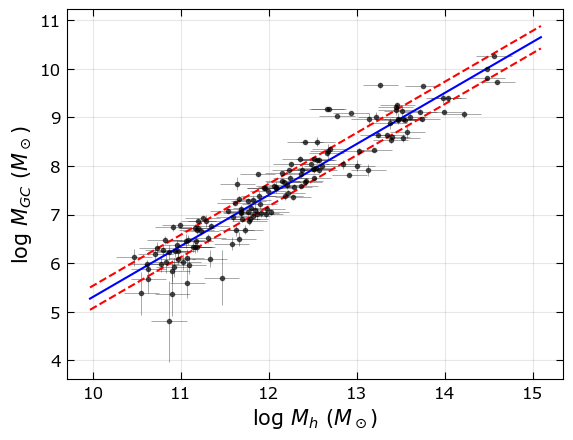

In [149]:
plt.errorbar(logM_h, logM_GC, xerr=dlogM_h, yerr=dlogM_GC, fmt='.k', elinewidth=0.4, capsize=0, alpha=0.6)

xa = np.linspace(x.min() - 0.5, x.max() + 0.5)
plt.plot(xa, a+b*xa, 'b-')

# plt.plot(xa, a+(da+sig)+(b-db)*(xa), 'r--', alpha=1)
plt.plot(xa, a+(sig)+(b)*(xa), 'r--', alpha=1)
plt.plot(xa, a-(sig)+(b)*(xa), 'r--', alpha=1)

plt.ylabel(r'log $M_{GC} \ (M_\odot)$')
plt.xlabel(r'log $M_{h} \ (M_\odot)$')
plt.grid(alpha=0.3)

2. Calculate bootstrap samples of the fit parameters until convergence, as in Project 4.<br>

In [150]:
def bootstrap_batch(batch_size, pboot, iboot):
    for i in range(batch_size):
        iboot += 1
        ir = np.random.randint(low=0, high=len(x), size=len(x))  # random numbers from 0 to N-1
        xb = x[ir]; yb = y[ir]; dxb = dx[ir]; dyb = dy[ir]       # bootstrap sample
        ob = optimize.minimize(neglogLikelihood, [1.,1.,1.], args=(xb, yb, dxb, dyb))
        [pboot[i].append(ob.x[i]) for i in [0,1,2]]

    return pboot, iboot

def convergence_criterion(pmean, pmean_last, epsilon):
    d_list = []
    has_not_converged = []

    # for each parameter, determine if not converged
    for i in range(len(pmean)):
        # d = abs((pmean[i] - pmean_last[i]) / pmean[i])
        d = abs(pmean[i] - pmean_last[i])
    
        if d < epsilon:
            has_not_converged.append(False)
            d_list.append(d)
        else:
            has_not_converged.append(True)
            d_list.append(d)

    return has_not_converged, d_list

In [151]:
np.random.seed(0)

pboot = [[], [], []]     # empty 2D array that will hold all bootstrap parameters

iboot = 0                # counter of bootstrap realizations
a_conv = True
b_conv = True
stdev_conv = True
epsilon = 1e-3
batch_size = 100
pmean = np.array([0, 0, 0])
pstd = np.array([1, 1, 1])

# while each parameter has not converged
while a_conv is True or b_conv is True or stdev_conv is True:

    # Run another batch
    pboot, iboot = bootstrap_batch(batch_size, pboot, iboot)

    # calculate if the parameters have converged
    pmean_last = pmean
    pstd_last = pstd
    pmean = np.array(np.mean(pboot, axis=1))
    pstd = np.std(pboot, axis=1)
    # print(pmean_last, pstd_last)
    has_not_converged, error = convergence_criterion(pstd, pstd_last, epsilon)
    # has_not_converged, error = convergence_criterion(pmean, pmean_last, epsilon)
    print(has_not_converged, iboot)
    a_conv = has_not_converged[0]
    b_conv = has_not_converged[1]
    stdev_conv = has_not_converged[2]

pmean = np.mean(pboot, axis=1) # means of the bootstrap parameter realizations
pstd = np.std(pboot, axis=1)   # standard deviations of the bootstrap parameter realizations

print('iboot = %4d a = %.4f +- %.4f b = %.4f +- %.4f sig = %.4f +- %.4f'\
    %(iboot, pmean[0], pstd[0], pmean[1], pstd[1], pmean[2], pstd[2]))

[True, True, True] 100
[True, False, False] 200
[True, False, False] 300
[True, False, True] 400
[True, False, False] 500
[True, False, False] 600
[True, False, False] 700
[True, False, False] 800
[True, False, False] 900
[True, False, False] 1000
[True, False, False] 1100
[False, False, False] 1200
iboot = 1200 a = -5.2000 +- 0.3172 b = 1.0504 +- 0.0266 sig = 0.0375 +- 0.2245


3. Make a scatter plot of bootstrap values of $a$ and $b$, and overplot on the same figure the contours of $2\ln{\cal L}_{\rm max\;}-2\ln{\cal L}(a,b) = 1$ and 2.71, on a finely-spaced grid of $a$ and $b$. Keep the value of the intrinsic scatter fixed at the best value determined above. Here ${\cal L}_{\rm max}\,$ is the maximum (best-fit) value of the likelihood. Refer to `week6_advanced_fitting` notebook for an example. Experiment with the number of grid points that produce smooth contours. Do these contours align with the bootstrap distribution of $a$ and $b$?<br>

In [152]:
# use correct sign for the likelihood, not -logL
def logLikelihood2(a, b):

    w = 1./(pstd[0]**2 + dy**2 + (b*dx)**2)
    logL = np.sum(np.log(w) - w*(y-a-b*x)**2)

    return logL

Text(0, 0.5, 'b')

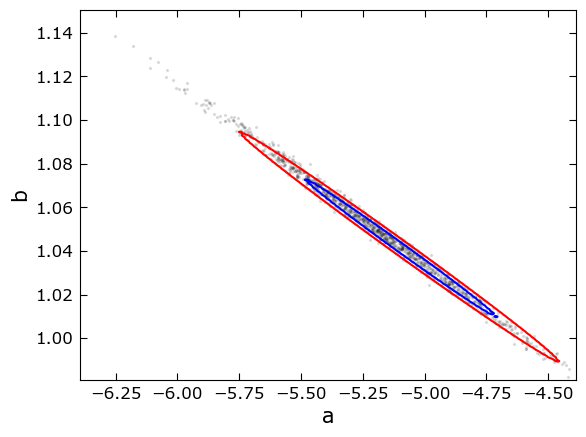

In [153]:
plt.scatter(pboot[0], pboot[1], color='k', s=2, alpha=0.1)

# number of points in a rectangular grid
na = 301
nb = 101
# rectangular grid with equal spacing
aaa = np.linspace(np.min(pboot[0]), np.max(pboot[0]), num=na)
bbb = np.linspace(np.min(pboot[1]), np.max(pboot[1]), num=nb)

# evaluate the likelihood on the grid
LL = np.ndarray((nb,na))
for i in range(nb):
    for j in range(na):
        LL[i,j] = logLikelihood2(aaa[j], bbb[i])

LLdiff = np.amax(LL)-LL
        
# plot contours of the differential likelihood relative to its maximum value
plt.contour(aaa, bbb, LLdiff, levels=[1, 2.71], colors=['b', 'r'])

plt.xlabel('a')
plt.ylabel('b')

4. Perform the reverse fit, that is, fit the model $x = c + d * y$, including intrinsic scatter. Add the best-fitting line to the first plot with the data and the forward fit.<br>

In [154]:
o = optimize.minimize(neglogLikelihood, [1.,1.,1.], args=(y, x, dy, dx))

c = o.x[0]
d = o.x[1]
sig_backwards = o.x[2]
dc = np.sqrt(o.hess_inv[0,0])
dd = np.sqrt(o.hess_inv[1,1])
dsig_backwards = np.sqrt(o.hess_inv[2,2])
                      
print('c = %.4f +- %.4f  d = %.4f +- %.4f  sig = %.4f +- %.4f'%(c, dc, d, dd, sig_backwards, dsig))

a_prime = - c / d
b_prime = 1 / d
da_prime = dc
db_prime = dd

c = 5.6330 +- 0.0039  d = 0.8628 +- 0.0024  sig = -0.2061 +- 0.0274


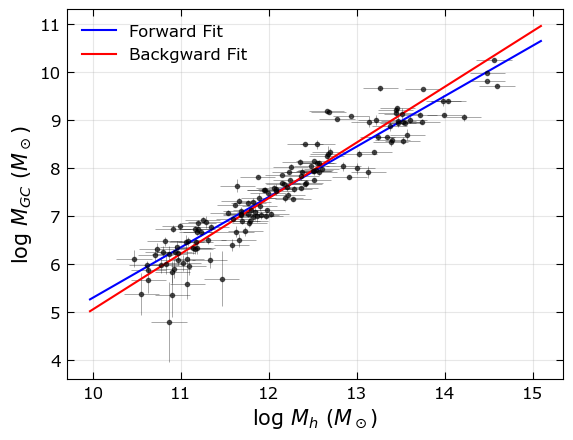

In [155]:
plt.errorbar(logM_h, logM_GC, xerr=dlogM_h, yerr=dlogM_GC, fmt='.k', elinewidth=0.4, capsize=0, alpha=0.6)

xa = np.linspace(x.min() - 0.5, x.max() + 0.5)
plt.plot(xa, a+b*xa, 'b-', label='Forward Fit')
plt.plot(xa, a_prime+b_prime*xa, 'r-', label='Backgward Fit')

plt.ylabel(r'log $M_{GC} \ (M_\odot)$')
plt.xlabel(r'log $M_{h} \ (M_\odot)$')
plt.grid(alpha=0.3)
plt.legend()

5. If the forward and reverse fits gave the same line, the parameters $a'$ and $b'$ corresponding to the new fit would be $a' = -c/d$, $b' = 1/d$. How do they compare with the original fit values? If they differ, explain why. Is the new slope consistent with 1, within the estimated uncertainty?<br>

In [156]:
print('a = %.4f +- %.4f  b = %.4f +- %.4f  sig = %.4f +- %.4f'%(a, da, b, db, sig, dsig))
print("a' = %.4f +- %.4f  b' = %.4f +- %.4f sig' = %.4f +- %.4f"%(a_prime, da_prime, b_prime, db_prime, sig_backwards, dsig_backwards))

print('b+db =', round(b+db, 4))

a = -5.1949 +- 0.2403  b = 1.0499 +- 0.0183  sig = 0.2304 +- 0.0274
a' = -6.5284 +- 0.0039  b' = 1.1590 +- 0.0024 sig' = -0.2061 +- 0.0019
b+db = 1.0682


The new slope, b'=1.1590, is not consistent with 1 within the estimated uncertainty, and neither is the original slope, b=1.0499). The two slopes are also not within the estimated uncertainty of each other.

6. Modify the original likelihood function to minimize the orthogonal distance of data points from the best-fitting line, including intrinsic scatter, as described in `week7_orthogonal_fit` notebook. The main modification of the merit function is to rotate the coordinate system by the angle $\theta = \arctan(b)$. Compare the best-fitting values of the parameters $a$, $b$, $\sigma$ with the original fit. Make a combined plot of all three models: original, reverse, and orthogonal, along with the data points. Include the errors of the fit parameters.<br>

In [157]:
def neglogLikelihood(p, x, y, dx, dy):
    a = p[0]
    b = p[1]
    sig = p[2]
    theta = np.arctan(b)

    delta = (y - a) * np.cos(theta) - x * np.sin(theta)
    sigma_squared = dy ** 2 * (np.cos(theta)) ** 2 + dx ** 2 * (np.sin(theta)) ** 2

    return -(-np.sum(np.log(sigma_squared + sig ** 2)) - np.sum(delta ** 2 / (sigma_squared + sig ** 2)))

In [165]:
o = optimize.minimize(neglogLikelihood, [1.,1.,1.], args=(x, y, dx, dy))

a_orthogonal = o.x[0]
b_orthogonal = o.x[1]
sig_orth = o.x[2]
da_orth = np.sqrt(o.hess_inv[0,0])
db_orth = np.sqrt(o.hess_inv[1,1])
dsig_orth = np.sqrt(o.hess_inv[2,2])
                      
print('Orthogonal a = %.4f +- %.4f b = %.4f +- %.4f sig = %.4f +- %.4f'%(a_orthogonal, da_orth, b_orthogonal, db_orth, sig_orth, dsig_orth))
print('Forward a = %.4f +- %.4f b = %.4f +- %.4f sig = %.4f +- %.4f'%(a, da, b, db, sig, dsig))
print("Backward a' = %.4f +- %.4f b' = %.4f +- %.4f sig = %.4f +- %.4f"%(a_prime, da_prime, b_prime, db_prime, sig_backwards, dsig_backwards))

Orthogonal a = -5.9021 +- 0.2489 b = 1.1078 +- 0.0203 sig = 0.1537 +- 0.0131
Forward a = -5.1949 +- 0.2403 b = 1.0499 +- 0.0183 sig = 0.2304 +- 0.0274
Backward a' = -6.5284 +- 0.0039 b' = 1.1590 +- 0.0024 sig = -0.2061 +- 0.0019


We can see from both the values and the plot that the orthogonal fit is inbetween the forward and backward fits.

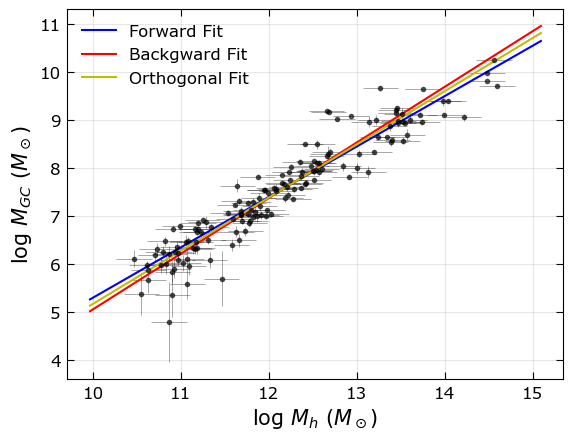

In [166]:
plt.errorbar(logM_h, logM_GC, xerr=dlogM_h, yerr=dlogM_GC, fmt='.k', elinewidth=0.4, capsize=0, alpha=0.6)

xa = np.linspace(x.min() - 0.5, x.max() + 0.5)
plt.plot(xa, a+b*xa, 'b-', label='Forward Fit')
plt.plot(xa, a_prime+b_prime*xa, 'r-', label='Backgward Fit')
plt.plot(xa, a_orthogonal+b_orthogonal*xa, 'y-', label='Orthogonal Fit')

plt.ylabel(r'log $M_{GC} \ (M_\odot)$')
plt.xlabel(r'log $M_{h} \ (M_\odot)$')
plt.grid(alpha=0.3)
plt.legend()

7. Discuss the differences in the three "best-fits" above. Argue which one you prefer. What do all these results combined indicate about the slope of the $M_{GC} - M_h$ relation? Is it consistent with the slope of 1 within the estimated uncertainty?<br>

The three best fits clearly all reveal the linear relationship of the relation between the log of the GC mass and halo mass. As expected, the orthogonal fit lies inbetween the forward and backward fits. The uncertainty of the lines do not include a slope of 1 for any of the three fits, giving evidence against the claim that the slope is 1. The uncertainty is smallest for the orthogonal fit, so I prefer that fit to the forward and backward fits. 

# Concluding Assessment

Which numerical methods worked or did not work in this project:
* Both forward and backward fits proved to give different results that fit the data in different but seemingly accurate ways (by eye).
* The orthogonal fit that lies inbetween the forward and backward fits.
* The bootstrapping worked to have each of the parameters converge to a certain accuracy.

Lessons learned:
* The orthogonal fit lying inbetween the forward and backward fits makes it good if the foward and backward fits are very different and the true answer is likely inbetween them.
* Try out multiple fits! The worst that happens is you realize there has been a mistake made, and best case scenario there are multiple great fits you get to choose from!

Further code improvements I could have made with significantly more effort:
* Tried even more fitting methods to compare with the three in this project.
* Add the pivot point and investigate the effects (positive and negative) of that.